In [1]:
# Data processing/formatting
from sklearn.preprocessing import MinMaxScaler
from seqprops import SequentialPropertiesEncoder
from sklearn.model_selection import train_test_split
from tools import one_hot_encode_list, one_hot_decode_list

# for building vae model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D, Dropout, RepeatVector, TimeDistributed, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# classic required packages
import os
import random
import pandas as pd
import numpy as np
from pylab import rcParams
import importlib
import importlib.resources

# packages for graphics
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard

In [2]:
file = 'amp.csv'
df = pd.read_csv(file)

peptides = df.loc[:, 'sequence'].values
peptides_type = df.loc[:, 'label'].values
print(peptides)
print(peptides_type)

# Determine the length of the longest sequence
max_peptide_len = 0
for peptide in peptides:
    max_peptide_len = max(len(peptide), max_peptide_len)
print("Max peptide length: ", max_peptide_len)

['GEP' 'QHP' 'YLRF' ...
 'MGSPEKLRPSDFSKSFLISSIRFAMSFSSFELYSACSSLIRVSSPTMAET'
 'MLLPATMSDKPDMAEIEKFDKSKLKKTETQEKNPLPSKETIEQEKQAGES'
 'GATIKKCVVDVKLSKPCTFQECQPLCLQKYNGNGLCPGDDNNICACVYNC']
[0 0 0 ... 0 0 1]
Max peptide length:  50


In [3]:
df['label'].value_counts()

0    5701
1    3708
Name: label, dtype: int64

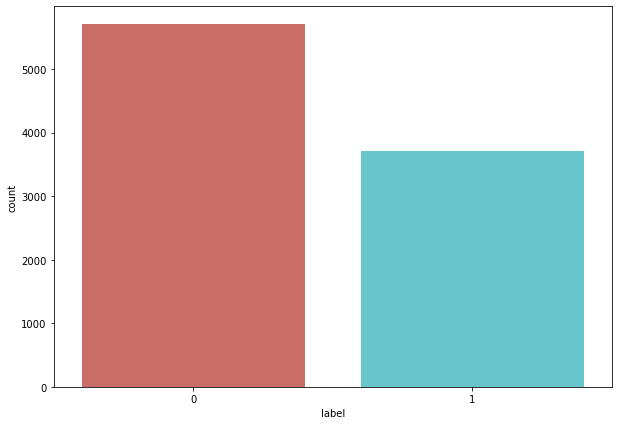

<Figure size 720x504 with 0 Axes>

In [4]:
rcParams['figure.figsize'] =  10,7
sns.countplot(x = 'label', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [5]:
### TRAIN TEST SPLIT ###
seqprops_encoder = SequentialPropertiesEncoder(scaler=MinMaxScaler(feature_range=(-1, 1)), max_seq_len=max_peptide_len - 1, stop_signal=True)
all_seq_encoded = seqprops_encoder.encode(peptides)
print("Shape of all sequences: ", all_seq_encoded.shape)
print("----------------------------")
train_size = 0.8

# 1 way (without randomize)
print("SequentialPropertiesEncoder without randomize")
sequence_input_train = all_seq_encoded[:int(len(all_seq_encoded) * train_size)]
sequence_input_test = all_seq_encoded[int(len(all_seq_encoded) * train_size):]
print(sequence_input_train.shape, sequence_input_test.shape)
sequence_target_train = peptides_type[:int(len(peptides_type) * train_size)]
sequence_target_test = peptides_type[int(len(peptides_type) * train_size):]

print("----------------------------")
print("SequentialPropertiesEncoder with randomize")
# 2 way (with randomize)
(x_train, x_test, y_train, y_test) = train_test_split(all_seq_encoded, peptides_type, test_size=0.2, random_state=42)

print(x_train.shape, x_test.shape)

# 3 way (one-hot encode)
print("----------------------------")
print("One-hot encode")
(x_train_peptides, x_test_peptides, y_train_peptide_types, y_test_peptide_types) = train_test_split(peptides, peptides_type, test_size=0.2, random_state=42)
x_train_onehotencoded = one_hot_encode_list(x_train_peptides)
x_train_onehotencoded = x_train_onehotencoded.reshape((7527, 50, 21))
x_test_onehotencoded = one_hot_encode_list(x_test_peptides)
x_test_onehotencoded = x_test_onehotencoded.reshape((1882, 50, 21))
print(x_train_onehotencoded.shape, x_test_onehotencoded.shape)

print("----------------------------")
# shape for Encoder input 
shape = x_train.shape[1:]
onehotencode_shape = x_train_onehotencoded.shape[1:]
print("shape for 1,2: ", shape)
print("shape for 3: ", onehotencode_shape)

Shape of all sequences:  (9409, 50, 95)
----------------------------
SequentialPropertiesEncoder without randomize
(7527, 50, 95) (1882, 50, 95)
----------------------------
SequentialPropertiesEncoder with randomize
(7527, 50, 95) (1882, 50, 95)
----------------------------
One-hot encode
(7527, 50, 21) (1882, 50, 21)
----------------------------
shape for 1,2:  (50, 95)
shape for 3:  (50, 21)


In [6]:
# Function for plotting latent space from encoded test data
def plot_input_data(encoder, x_data, y_data, title):
    z_input, _ = encoder.predict(x_data)
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title(title)
    plt.legend()
    plt.show()

In [7]:
# Function for plotting latent space from reconstructed decoder data
def plot_reconstructed_data(encoder, decoder, x_data, y_data, title):
    z_input, _ = encoder.predict(x_data)
    reconstructed_input = decoder.predict(z_input)
    reconstruced_z_input, _ = encoder.predict(reconstructed_input)
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(reconstruced_z_input[indices, 0], reconstruced_z_input[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title(title)
    plt.legend()
    plt.show()

In [8]:
title_enc_training_data = "Podaci za trening enkodirani u latentni prostor"
title_enc_test_data = "Podaci za test enkodirani u latentni prostor"
title_recon_enc_training_data = "Rekonstruirani trening podaci enkodirani u latentni prostor"
title_recon_enc_test_data ="Rekonstruirani testni podaci enkodirani u latentni prostor"

In [9]:
def create_seq_encoder_model(input_shape, latent_dim=2, lstm_cells=64):
    inp = Input(shape=input_shape, name="input_1_enc")
    x = LSTM(lstm_cells, unroll=True, name="lstm_enc")(inp)
    z = Dense(32, activation='relu', name="output_dense_enc")(x)
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
    
    encoder_model = Model(inputs=inp, outputs=[z_mean, z_log_sigma], name="encoder")
    return encoder_model

In [10]:
def create_seq_decoder_model(input_shape, latent_dim=2, lstm_cells=64):
    model_input = Input(shape=(latent_dim,), name="input_1_dec")
    x = RepeatVector(input_shape[0])(model_input)
    x = LSTM(lstm_cells, unroll=True, name="lstm_dec", return_sequences=True)(x)
    out = TimeDistributed(Dense(input_shape[1], activation='linear'))(x)
    
    decoder_model = Model(inputs=model_input, outputs=out, name="decoder")
    return decoder_model

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_seed(self, seed):
        self.random_seed = seed
        tf.random.set_seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        random.seed(seed)
    
    # Sampling from latent space
    def sampling(self, args):
        z_mean, z_log_sigma = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma = self.encoder(data)
            z = Lambda(self.sampling)([z_mean, z_log_sigma])
            reconstruction = self.decoder(z)
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1)
            )
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=1
                )
            )
            total_loss = reconstruction_loss + kl_loss
                                        
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x = data[0]
        z_mean, z_log_sigma = self.encoder(data)
        z = Lambda(self.sampling)([z_mean, z_log_sigma])
        reconstructed_x = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1)
            )

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(data, reconstructed_x), axis=1
            )
        )
        total_loss = reconstruction_loss + kl_loss
        self.compiled_metrics.update_state(x, reconstructed_x)

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results

In [12]:
def set_seed(seed):
        random_seed = seed
        tf.random.set_seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        random.seed(seed)
        
set_seed(31)
        
encoder = create_seq_encoder_model(input_shape=shape)
encoder.summary()
decoder = create_seq_decoder_model(input_shape=shape, latent_dim=2)
decoder.summary()
vae = VAE(encoder, decoder)
vae.set_seed(31)

vae.compile(loss=None, optimizer=keras.optimizers.Adam(learning_rate=1e-3))

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_enc (InputLayer)       [(None, 50, 95)]     0           []                               
                                                                                                  
 lstm_enc (LSTM)                (None, 64)           40960       ['input_1_enc[0][0]']            
                                                                                                  
 output_dense_enc (Dense)       (None, 32)           2080        ['lstm_enc[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 2)            66          ['output_dense_enc[0][0]']       
                                                                                            

In [13]:
es = EarlyStopping(patience=5, verbose=1, min_delta=0.01, monitor='loss', mode='auto', restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Run this in terminal to open server for showing loss function graphs
# tensorboard --logdir=C:\Users\StarLord\Documents\Diplomski\VAEs\tmp\autoencoder

# First VAE model - without randomized input data
# sequence_input_train, sequence_input_test, sequence_target_train, sequence_target_test
vae.fit(sequence_input_train, batch_size=128, epochs=100, 
        validation_data=(sequence_input_test, None), 
        shuffle=False,
        callbacks=[TensorBoard(log_dir='C:\\Users\\StarLord\\Documents\\Diplomski\\VAEs\\tmp\\autoencoder'), es])
# vae.fit(sequence_input_train, batch_size=128, epochs=100, 
#         validation_data=(sequence_input_test, None), 
#         shuffle=False,
#         callbacks=[es])

Epoch 1/100
59/59 [==============================] - 35s 173ms/step - loss: 6.3836 - reconstruction_loss: 9.1272 - kl_loss: 0.0067 - val_total_loss: 15.9168 - val_reconstruction_loss: 15.8888 - val_kl_loss: 0.0280
Epoch 2/100
59/59 [==============================] - 7s 124ms/step - loss: 6.1931 - reconstruction_loss: 8.8279 - kl_loss: 0.0019 - val_total_loss: 16.1243 - val_reconstruction_loss: 16.1018 - val_kl_loss: 0.0226
Epoch 3/100
59/59 [==============================] - 7s 116ms/step - loss: 6.0101 - reconstruction_loss: 8.7240 - kl_loss: 0.0014 - val_total_loss: 15.9096 - val_reconstruction_loss: 15.8759 - val_kl_loss: 0.0337
Epoch 4/100
59/59 [==============================] - 7s 120ms/step - loss: 6.0497 - reconstruction_loss: 8.6634 - kl_loss: 2.5192e-04 - val_total_loss: 15.9880 - val_reconstruction_loss: 15.9620 - val_kl_loss: 0.0260
Epoch 5/100
59/59 [==============================] - 6s 108ms/step - loss: 6.0642 - reconstruction_loss: 8.6889 - kl_loss: 1.9523e-04 - val_tot

59/59 [==============================] - 2s 12ms/step


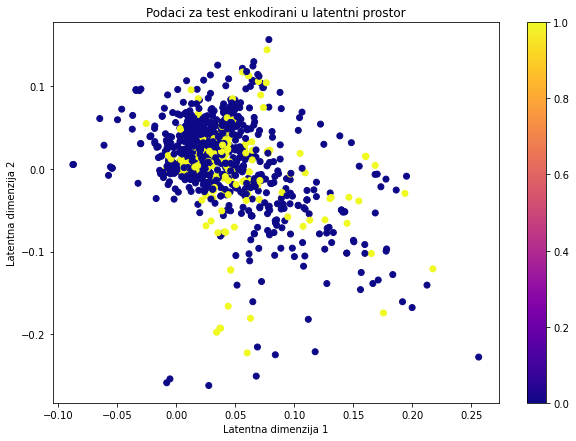

In [14]:
enc_pred, _ = vae.encoder.predict(sequence_input_test)
plt.scatter(enc_pred[:,0], enc_pred[:,1], c=sequence_target_test ,cmap='plasma')
plt.xlabel("Latentna dimenzija 1")
plt.ylabel("Latentna dimenzija 2")
plt.title("Podaci za test enkodirani u latentni prostor")
plt.colorbar()
plt.show()

236/236 [==============================] - 2s 10ms/step


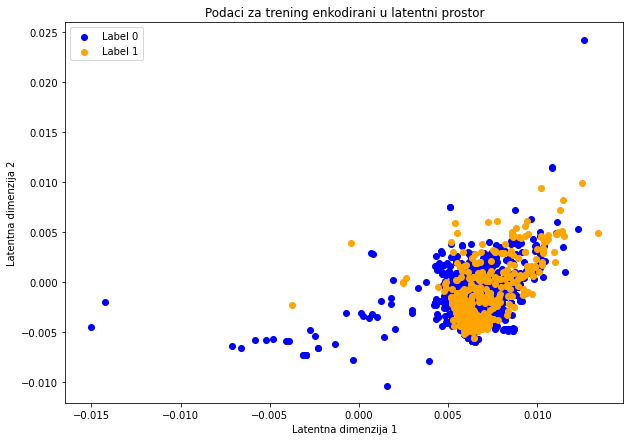

236/236 [==============================] - 2s 9ms/step


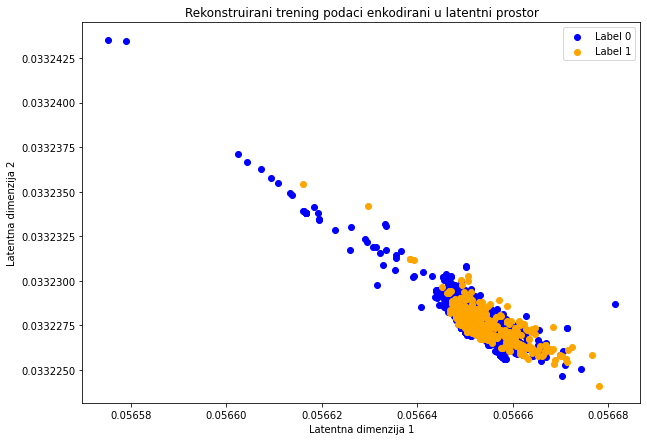

59/59 [==============================] - 1s 9ms/step


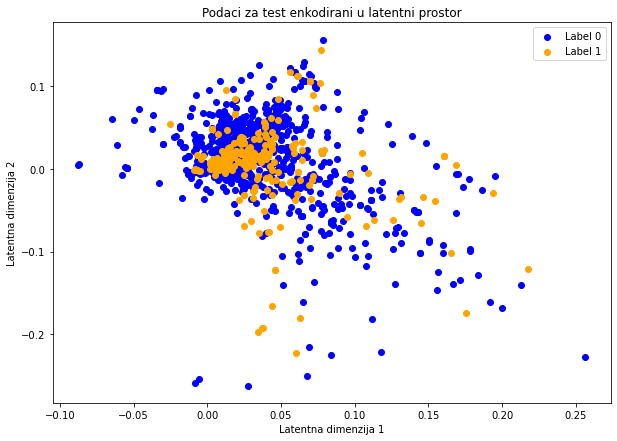

59/59 [==============================] - 1s 13ms/step


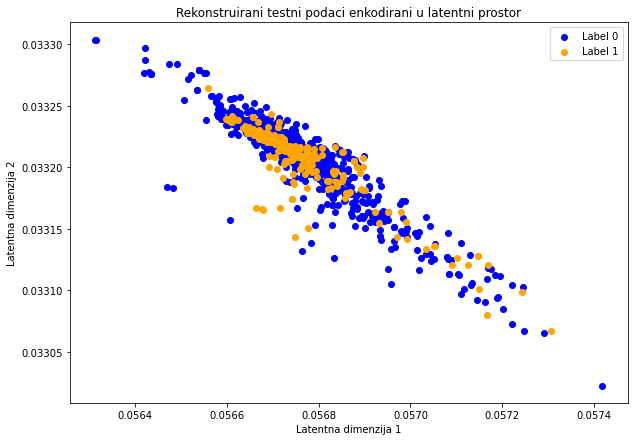

In [15]:
# sequence_input_train, sequence_input_test, sequence_target_train, sequence_target_test
# train data in latent space
plot_input_data(vae.encoder, sequence_input_train, sequence_target_train, title_enc_training_data)
# reconstructed train data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, sequence_input_train, sequence_target_train, title_recon_enc_training_data)
# test data in latent space
plot_input_data(vae.encoder, sequence_input_test, sequence_target_test, title_enc_test_data)
# reconstructed test data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, sequence_input_test, sequence_target_test, title_recon_enc_test_data)

In [16]:
# FROM SEQUENCE TO LETTERS
enc_pred, _ = vae.encoder.predict(sequence_input_test)
decoded_data = vae.decoder.predict(enc_pred)

def closest_letter(unknown_seq):
    min_dif = 999999999999999
    current_closest_letter = None
    
    for letter, seq in seqprops_encoder.mappings.items():
        if np.correlate(unknown_seq, seq)[0] < min_dif:
            min_dif = np.correlate(unknown_seq, seq)[0]
            current_closest_letter = letter
    
    return current_closest_letter

decoded_data_original_sequence_input = []
seq_to_letter = ''
for sequence_array in decoded_data:
    for seq in sequence_array:
        seq_to_letter += closest_letter(seq)
    decoded_data_original_sequence_input.append(seq_to_letter)
    seq_to_letter = ''
    
print(decoded_data_original_sequence_input)

59/59 [==============================] - 1s 13ms/step
['RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWW', 'RRRRRRRRRRRRRRRRRRRRRRRRRR

In [17]:
es = EarlyStopping(patience=5, verbose=1, min_delta=0.01, monitor='loss', mode='auto', restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Second VAE model - with randomized input data
# x_train, x_test, y_train, y_test
vae.fit(x_train, batch_size=128, epochs=100, 
        validation_data=(x_test, None), 
        shuffle=False,
        callbacks=[es])

Epoch 1/100
59/59 [==============================] - 6s 109ms/step - loss: 9.8935 - reconstruction_loss: 9.9252 - kl_loss: 2.2591e-04 - val_total_loss: 10.4013 - val_reconstruction_loss: 10.4012 - val_kl_loss: 1.4556e-04
Epoch 2/100
59/59 [==============================] - 7s 115ms/step - loss: 9.8263 - reconstruction_loss: 9.8956 - kl_loss: 2.9039e-05 - val_total_loss: 10.4125 - val_reconstruction_loss: 10.4125 - val_kl_loss: 4.4762e-05
Epoch 3/100
59/59 [==============================] - 6s 108ms/step - loss: 9.8220 - reconstruction_loss: 9.8914 - kl_loss: 3.2593e-05 - val_total_loss: 10.3914 - val_reconstruction_loss: 10.3914 - val_kl_loss: 2.5907e-05
Epoch 4/100
59/59 [==============================] - 7s 125ms/step - loss: 9.8192 - reconstruction_loss: 9.8887 - kl_loss: 2.5921e-05 - val_total_loss: 10.3899 - val_reconstruction_loss: 10.3898 - val_kl_loss: 4.3791e-05
Epoch 5/100
59/59 [==============================] - 8s 136ms/step - loss: 9.8164 - reconstruction_loss: 9.8866 - kl

59/59 [==============================] - 1s 9ms/step


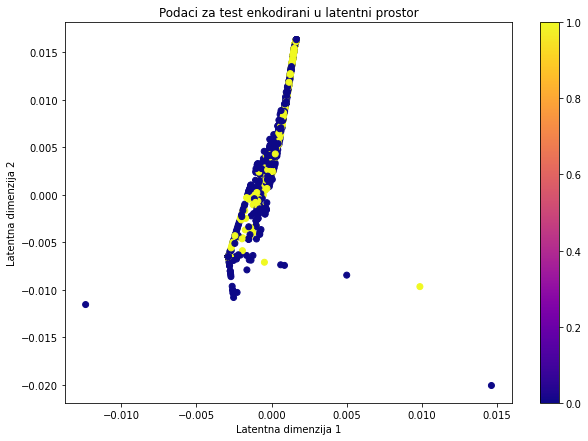

In [18]:
enc_pred, _ = vae.encoder.predict(x_test)
plt.scatter(enc_pred[:,0], enc_pred[:,1], c=y_test ,cmap='plasma')
plt.xlabel("Latentna dimenzija 1")
plt.ylabel("Latentna dimenzija 2")
plt.title("Podaci za test enkodirani u latentni prostor")
plt.colorbar()
plt.show()

236/236 [==============================] - 2s 7ms/step


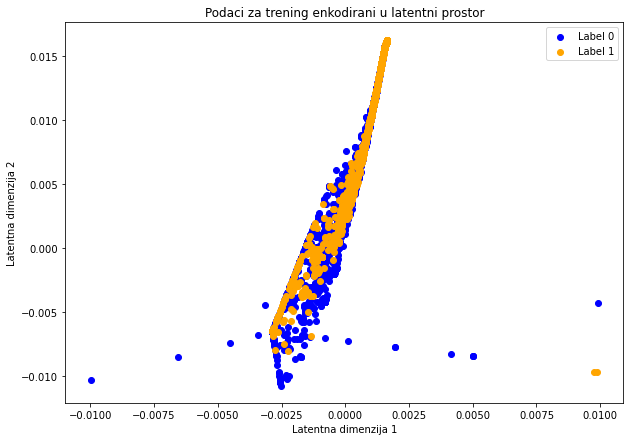

236/236 [==============================] - 2s 8ms/step


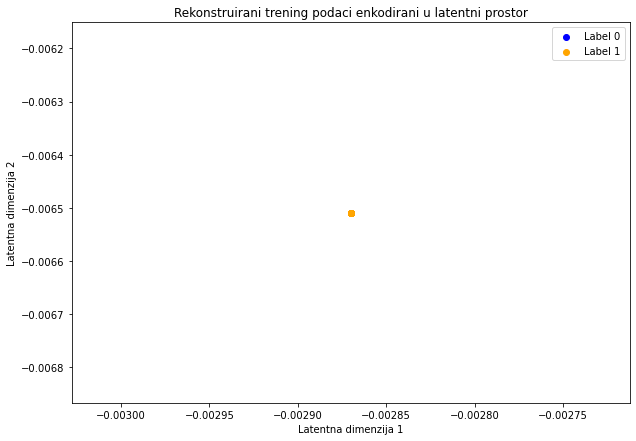

59/59 [==============================] - 1s 8ms/step


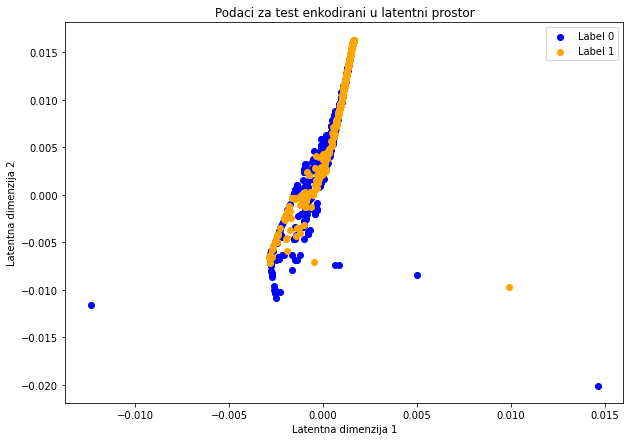

59/59 [==============================] - 0s 7ms/step


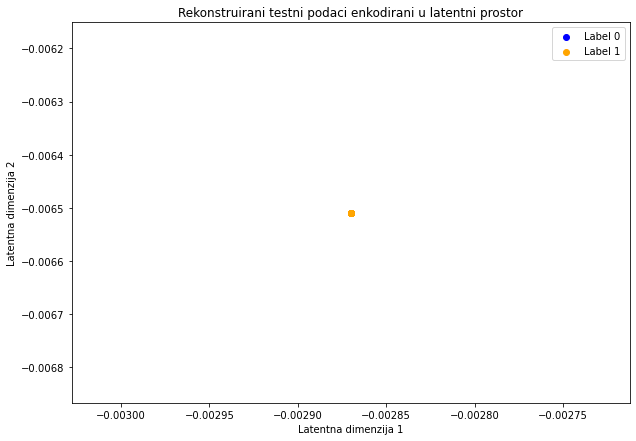

In [19]:
# x_train, x_test, y_train, y_test
# train data in latent space
plot_input_data(vae.encoder, x_train, y_train, title_enc_training_data)
# reconstructed train data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, x_train, y_train, title_recon_enc_training_data)
# test data in latent space
plot_input_data(vae.encoder, x_test, y_test, title_enc_test_data)
# reconstructed test data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, x_test, y_test, title_recon_enc_test_data)

In [20]:
# FROM SEQUENCE TO LETTERS
enc_pred, _ = vae.encoder.predict(x_test)
decoded_data = vae.decoder.predict(enc_pred)

def closest_letter(unknown_seq):
    min_dif = 999999999999999
    current_closest_letter = None
    
    for letter, seq in seqprops_encoder.mappings.items():
        if np.correlate(unknown_seq, seq)[0] < min_dif:
            min_dif = np.correlate(unknown_seq, seq)[0]
            current_closest_letter = letter
    
    return current_closest_letter

decoded_data_original_x_input = []
seq_to_letter = ''
for sequence_array in decoded_data:
    for seq in sequence_array:
        seq_to_letter += closest_letter(seq)
    decoded_data_original_x_input.append(seq_to_letter)
    seq_to_letter = ''
    
print(decoded_data_original_x_input)

59/59 [==============================] - 0s 7ms/step
['RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWWWWWWWWWWWWWWWWWWWWWWFFF', 'RRRRRRRRRRRRRRRRRRRRRRWWWWW

In [21]:
encoder = create_seq_encoder_model(input_shape=onehotencode_shape)
encoder.summary()
decoder = create_seq_decoder_model(input_shape=onehotencode_shape, latent_dim=2)
decoder.summary()
vae = VAE(encoder, decoder)
vae.set_seed(31)
vae.compile(optimizer=keras.optimizers.Adam())

# Thrid VAE model - with one-hot encoded data randomized data
# x_train_onehotencoded, x_test_onehotencoded, y_train_peptide_types, y_test_peptide_types
vae.fit(x_train_onehotencoded, batch_size=128, epochs=100, 
        validation_data=(x_test_onehotencoded, None), 
        shuffle=False,
        callbacks=[es])

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_enc (InputLayer)       [(None, 50, 21)]     0           []                               
                                                                                                  
 lstm_enc (LSTM)                (None, 64)           22016       ['input_1_enc[0][0]']            
                                                                                                  
 output_dense_enc (Dense)       (None, 32)           2080        ['lstm_enc[0][0]']               
                                                                                                  
 dense_3 (Dense)                (None, 2)            66          ['output_dense_enc[0][0]']       
                                                                                            

59/59 [==============================] - 2s 8ms/step


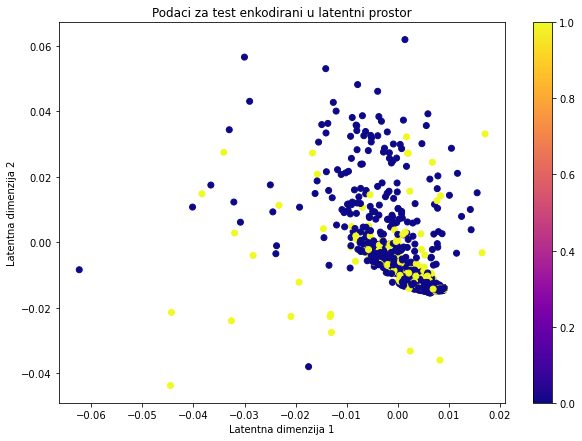

In [22]:
enc_pred, _ = vae.encoder.predict(x_test_onehotencoded)
plt.scatter(enc_pred[:,0], enc_pred[:,1], c=y_test_peptide_types ,cmap='plasma')
plt.xlabel("Latentna dimenzija 1")
plt.ylabel("Latentna dimenzija 2")
plt.title("Podaci za test enkodirani u latentni prostor")
plt.colorbar()
plt.show()

236/236 [==============================] - 2s 7ms/step


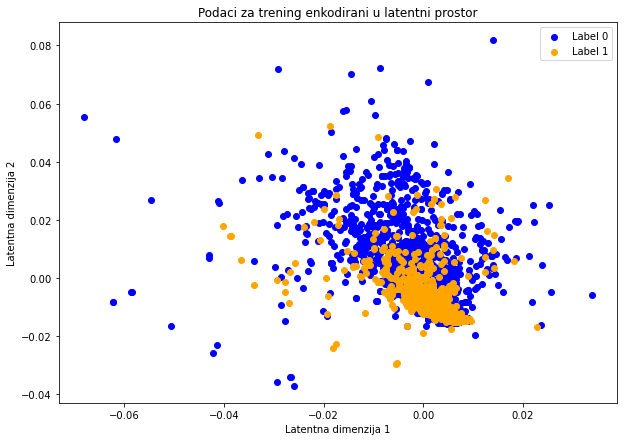

236/236 [==============================] - 2s 8ms/step


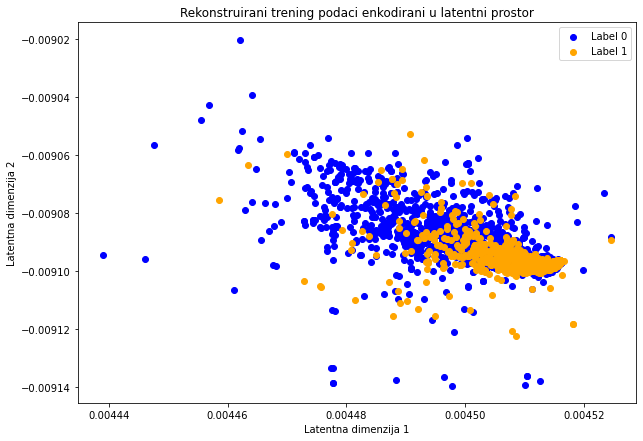

59/59 [==============================] - 0s 8ms/step


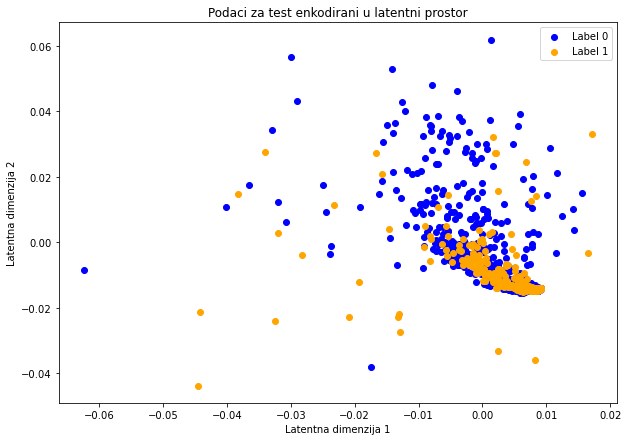

59/59 [==============================] - 1s 9ms/step


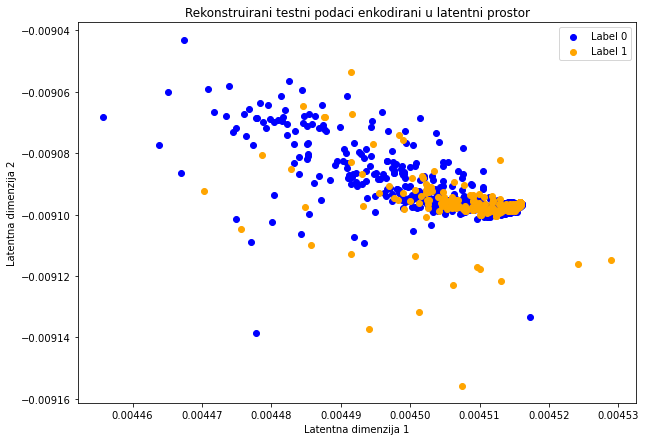

In [23]:
# x_train_onehotencoded, x_test_onehotencoded, y_train_peptide_types, y_test_peptide_types
# train data in latent space
plot_input_data(vae.encoder, x_train_onehotencoded, y_train_peptide_types, title_enc_training_data)
# reconstructed train data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, x_train_onehotencoded, y_train_peptide_types, title_recon_enc_training_data)
# test data in latent space
plot_input_data(vae.encoder, x_test_onehotencoded, y_test_peptide_types, title_enc_test_data)
# reconstructed test data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, x_test_onehotencoded, y_test_peptide_types, title_recon_enc_test_data)

In [31]:
# decoded_data ne vrati se u obliku 0,1 nego sekvenci 
# print(x_test_onehotencoded)
# print(decoded_data)
# peptides_decoded = one_hot_decode_list(decoded_data)
# print(peptides_decoded)

# FROM SEQUENCE TO LETTERS
enc_pred, _ = vae.encoder.predict(x_test_onehotencoded)
decoded_data = vae.decoder.predict(enc_pred)

def closest_letter(unknown_seq):
    min_dif = 999999999999999
    current_closest_letter = None
    
    for letter, seq in seqprops_encoder.mappings.items():
        if np.correlate(unknown_seq, seq)[0] < min_dif:
            min_dif = np.correlate(unknown_seq, seq)[0]
            current_closest_letter = letter
    
    return current_closest_letter

decoded_data_original_onehotencode_input = []
seq_to_letter = ''
for sequence_array in decoded_data:
    for seq in sequence_array:
        seq_to_letter += closest_letter(seq)
    decoded_data_original_onehotencode_input.append(seq_to_letter)
    seq_to_letter = ''
    
print(decoded_data_original_onehotencode_input)

59/59 [==============================] - 1s 10ms/step
['PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCC', 'PPPPPPPPPPPPPPPPPPPPPPPPPP